In [1]:
#Import dataset
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plimg
from PIL import Image
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb')as f:
        datadict = p.load(f,encoding='latin1')
        #print(datadict.keys())
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32)
        Y = np.array(Y)
        return X, Y

X1,Y1=load_CIFAR_batch('data_batch_1')
X2,Y2=load_CIFAR_batch('data_batch_2')
X3,Y3=load_CIFAR_batch('data_batch_3')
X4,Y4=load_CIFAR_batch('data_batch_4')
X5,Y5=load_CIFAR_batch('data_batch_5')
X_test,Y_test=load_CIFAR_batch('test_batch')
  
X0=np.vstack((X1,X2,X3,X4,X5)).reshape(50000,3072)
X0=X0/256
Y0=np.hstack((Y1,Y2,Y3,Y4,Y5)).reshape((50000,1))
data0=np.hstack((X0,Y0))
data = data0[data0[:,-1].argsort()]
X=data[:,0:3072]
Y=data[:,3072:3073]
x_test=X_test/256
x_test=x_test.reshape(10000,3072)

error rate 0.626


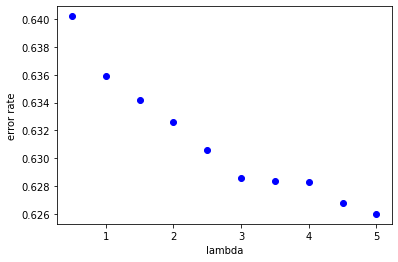

In [3]:
# cross validation
Iv = [[]] * 5
Ir = [[]] * 5
x_train,y_train,x_hold,y_hold=[[]]*5,[[]]*5,[[]]*5,[[]]*5
for m in range(5):
    Iv[m] = range(m,50000,5)
    Ir[m] = np.setdiff1d(range(50000),Iv[m])
    x_train[m]=X[Ir[m]]
    y_train[m]=Y[Ir[m]]
    y_train[m]=y_train[m].reshape(40000,1)
    x_hold[m]=X[Iv[m]]
    y_hold[m]=Y[Iv[m]]
    y_hold[m]=y_hold[m].reshape(10000,1)

# 1 vs all using Ridge regularization
lamda_=np.linspace(0.5,5,10)
error_rate=[]
for lamda in lamda_:
    w=[[]]*5
    error_cross=[]
    for n in range(5):
        w[n]=[[]]*10
        error_cross=[]
        label=np.zeros((10000,10))
        for k in range(10):
            y=y_train[n].copy()
            y[y_train[n]==k],y[y_train[n]!=k]=0,1
            w[n][k]=np.linalg.inv(x_train[n].T@x_train[n]+lamda*np.identity(3072))@x_train[n].T@y
            label[:,k:k+1]=x_hold[n]@w[n][k]
        y_predict=np.argmin(label,axis=1)
        error_cross.append(np.mean(y_predict!=y_hold[n]))

    w_best=w[error_cross.index(min(error_cross))]    

    # test
    predict=np.zeros((10000,10))
    for i in range(10):
        predict[:,i:i+1]=x_test@w_best[i]
    label=np.argmin(predict,axis=1)
    error_rate.append(np.mean(label!=Y_test))
print('error rate',min(error_rate))
plt.plot(lamda_,error_rate,'bo')
plt.xlabel('lambda')
plt.ylabel('error rate')
plt.show()

In [ ]:
# Ridge Regression Function
def weight(A,y,la):
    p,n= A.shape
    num_lam = len(la)
    X = np.zeros((n, num_lam))
    for k,each_lamda in enumerate(la):
        X[:,k:k+1]=np.linalg.inv((A@A.T+each_lamda*np.eye(p)))@A.T@y
    return X
# 1 vs all
w=[[]]*5
error_cross=[]
for n in range(5):
    w[n]=[[]]*10
    label=np.zeros((5000,10))
    for k in range(10):
        y=y_train[n].copy()
        y[y_train[n]==k],y[y_train[n]!=k]=0,1
        w[n][k]=np.linalg.inv(x_train[n].T@x_train[n])@x_train[n].T@y
        label[:,k:k+1]=x_hold[n]@w[n][k]
    

    for j in range(5000):
        result=[]
        for i in range(10):
            y=y_hold[n].copy()
            y[y_hold[n]==i],y[y_hold[n]!=i]=0,1
            predict=x_hold[n][j]@w[n][i]
            result.append(predict)
        label=result.index(min(result))
        if label!=y_hold[n][j]:
            error+=1
    error_cross.append(error) 
        
w_best=w[error_cross.index(min(error_cross))]    

# test
error=0
for m in range(10000):
    result=[]
    for n in range(10):
        predict=x_test[m]@w_best[n]
        result.append(predict)
    label=result.index(min(result))
    if label!=Y_test[m]:
        error+=1
print('error rate=\n',error/10000)
